In [168]:
import pandas as pd
import numpy as np
from sklearn.datasets import make_classification, make_blobs, fetch_openml
import sklearn.datasets as datasets
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,f1_score
import matplotlib.pyplot as plt
from pandas.api.types import is_numeric_dtype


class PrismRules:
    def __init__(self, min_coverage=10, min_prob=0.75, nbins=3, verbose=0):
        """
        Class to generate PRISM rules for a supplied dataset.

        :param min_coverage: The minimum number of rows each rule must cover.
        :param min_prob: The minimum probability for each rule. The target class must be the target value in the
            remaining rows (the rows not covered by previous rules) with at least this probability.
        :param nbins: The number of bins each numeric column is divided into.
        :param verbose: If 0, no output is produced other than the induced rules. If 1, progress indication is
            presented as each rule is induced.
        """

        self.min_coverage = min_coverage
        self.min_prob = min_prob
        self.nbins = nbins
        self.bin_ranges = {}
        self.verbose = verbose
        self.default_target = None
        self.predict_dict = {}
        self.target_column = ""

        # For improved performance, integer values are used for each value. This dictionary maps the integer codes
        # to the original values, and is used to display the rules and target values. Where the column is numeric,
        # this maps to the bin label.
        self.int_to_values_map = {}

    def __get_next_term(self, df, target_col, target_val, cols_exclude_list):
        """
        Get the next term (a column-value pair) for the current rule.

        :param df: The dataframe for the current rule. This is the set of rows matching the rule so far.
        :param target_col: Target column
        :param target_val: The current target value within the target column
        :param cols_exclude_list: Columns for which we already have terms for this rule.
        :return: a single term in tuple format, with a column name and value from that column, along with the
            probability and coverage (frequency) of the rule on the remaining rows.
        """

        max_prob = -1
        # In the event of ties with respect to probability, we take the term with the greatest frequency
        max_prob_freq = 0
        term = None
        for col_name in df.drop(columns=[target_col]).columns:
            if col_name in cols_exclude_list:
                continue
            for val in df[col_name].unique():
                sub_df_1 = df[df[col_name] == val]
                sub_df_2 = df[(df[col_name] == val) & (df[target_col] == target_val)]
                prob = len(sub_df_2) / len(sub_df_1)
                freq = len(sub_df_2)
                if freq < self.min_coverage:
                    continue
                if (prob > max_prob) or ((prob == max_prob) and (freq > max_prob_freq)):
                    max_prob = prob
                    max_prob_freq = freq
                    term = (col_name, val, prob, freq)
        return term

    def __get_next_rule(self, df_rule, target_col, target_val):
        """
        Given a specified target_val in the target_col, find the first or next rule. If not the first, the dataframe
        should just contain rows not covered by the previous rules for this target value.

        :param df_rule: the full original dataframe, minus the rows covered by other rules for the current target
        :param target_col: the target column
        :param target_val: the target value
        :return: a list of terms for the new rule, and a dataframe with the rows for this rule
        """

        terms_list = []
        cols_exclude_list = []  # Do not create terms for the same feature in the same rule
        df = df_rule.copy()
        target_val_remaining = df[target_col].tolist().count(target_val)
        len_df = len(df)
        while target_val_remaining < len_df:
            term = self.__get_next_term(df, target_col, target_val, cols_exclude_list)
            if term is None:
                break
            col, val, prob, freq = term
            cols_exclude_list.append(col)
            if len(cols_exclude_list) == (len(df.columns) - 1):
                break
            df = df[(df[col] == val)]
            terms_list.append((term, df))
            target_val_remaining = df[target_col].tolist().count(target_val)
            len_df = len(df)

        # Check the terms list for the optimal set of terms, which is the set with the highest probability of the
        # target class given the terms.
        max_prob = 0
        max_prob_idx = -1
        max_prob_df = None
        for term_idx, term in enumerate(terms_list):
            if term[0][2] > max_prob:
                max_prob = term[0][2]
                max_prob_idx = term_idx
                max_prob_df = term[1]
        optimal_terms_list = terms_list[:max_prob_idx + 1]
        optimal_terms_list = [x for x, y in optimal_terms_list]

        if max_prob < self.min_prob:
            return None, None

        # Convert the integer codes used in the dataframe to the original values for the relevant column
        formatted_terms = []
        for t in optimal_terms_list:
            if t[1] == "NONE":
                formatted_terms.append(t)
            else:
                formatted_terms.append((t[0], self.int_to_values_map[t[0]][t[1]], t[2], t[3]))

        return formatted_terms, max_prob_df

    def __get_rules_for_target_val(self, df_full, target_col, target_val):
        """
        Get the full set of rules for the specified value in the target column
        :param df_full:
        :param target_col:  Name of target column
        :param target_val:  Value in the target column for which this execution of this function generates rules.
        :return: array of strings.
        """

        rules_for_val = []
        num_rows_curr_target = df_full[target_col].tolist().count(target_val)
        df = df_full.copy()  # Create a temporary dataframe that shrinks as the rules are formed
        is_first_rule = True
        target_val_remaining = df[target_col].tolist().count(target_val)
        while target_val_remaining > self.min_coverage:
            if self.verbose:
                print(f"  Determining next rule. {target_val_remaining:,} rows remaining for target class")
            num_rows_curr_target_remaining = df[target_col].tolist().count(target_val)
            terms_list, rule_df = self.__get_next_rule(df, target_col, target_val)
            if not terms_list:
                break

            if target_val in self.predict_dict:
                self.predict_dict[target_val].append(terms_list)
            else:
                self.predict_dict[target_val] = [terms_list]

            # Add a rule in string format representing the list of terms returned
            rule_str = ""
            for term in terms_list:
                rule_str += str(term[0]) + " = " + str(term[1]) + " AND "
            rule_str = rule_str[:-5]  # Remove the trailing "AND"
            num_matching_target = rule_df[target_col].tolist().count(target_val)
            rule_str += "\n   Support:  "
            if is_first_rule:
                rule_str += f"the target has value: '{self.int_to_values_map[target_col][target_val]}' for "
                rule_str += f"{terms_list[-1][2] * 100:.3f}% of the {num_matching_target} rows matching the rule "
                rule_str += "\n   Coverage: "
                rule_str += f"the rule matches: {num_matching_target} out of {num_rows_curr_target} rows "
                rule_str += f"for target value: '{self.int_to_values_map[target_col][target_val]}'. This is:"
            else:
                rule_str += f"The target has value: '{self.int_to_values_map[target_col][target_val]}' for "
                rule_str += f"{terms_list[-1][2] * 100:.3f}% of the {num_matching_target} remaining rows matching the "
                rule_str += "rule"
                rule_str += "\n   Coverage: "
                rule_str += f"The rule matches: {num_matching_target} out of {num_rows_curr_target_remaining} rows "
                rule_str += f"remaining for target value: '{self.int_to_values_map[target_col][target_val]}'. This is:"
                rule_str += f"\n      {(num_matching_target * 100.0 / num_rows_curr_target_remaining):.3f}% of "
                rule_str += f"remaining rows for target value: '{self.int_to_values_map[target_col][target_val]}'"
            rule_str += f"\n      {(num_matching_target * 100.0 / num_rows_curr_target):.3f}% of total rows for target "
            rule_str += f"value: '{self.int_to_values_map[target_col][target_val]}'"
            rule_str += f"\n      {(num_matching_target * 100.0 / len(df_full)):.3f}% of total rows in data"
            rules_for_val.append(rule_str)
            is_first_rule = False

            # Remove all rows for this rule
            df = df.loc[list(set(df.index) - set(rule_df.index))]
            target_val_remaining = df[target_col].tolist().count(target_val)
        return rules_for_val

    def __display_rules(self, df, target_col, rules_dict, display_stats):
        for target_val in rules_dict:
            print()
            print('........................................................................')
            print(f"Target: {self.int_to_values_map[target_col][target_val]}")
            print('........................................................................')
            if len(rules_dict[target_val]) == 0 and display_stats:
                print((f"  No rules imputed for target value {self.int_to_values_map[target_col][target_val]}. There "
                       f"are {df[target_col].tolist().count(target_val)} rows for this class."))
            for r in rules_dict[target_val]:
                if display_stats:
                    print(r)
                else:
                    print(r.split("\n")[0])

    def get_prism_rules(self, df, target_col, display_stats=True):
        """
        Given a dataframe with a specified target column, find a set of rules that describe the patterns associated
        with the target column. The rules are displayed in a formatted form.

        :param df: pandas dataframe. Must include the target column.
        :param target_col: Name of the target column
        :param display_stats: If True, the support and coverage for each rule will be displayed
        :return: array of strings, with each element of the array representing one rule.
        """

        # PRISM requires all columns be categorical, so bin any numeric features, including the target column if
        # necessary.
        new_vals_dict = {}
        for col_name in df.columns:
            if is_numeric_dtype(df[col_name]) and (df[col_name].nunique() > 10):
                try:
                    if self.nbins == 3:
                        vals = ['Low', "Med", 'High']
                        bin_ids, bin_ranges = pd.qcut(df[col_name], 3, labels=vals, retbins=True)
                    else:
                        vals = [f"Bin_{x}" for x in range(self.nbins)]
                        bin_ids, bin_ranges = pd.qcut(df[col_name], self.nbins, labels=vals, retbins=True)
                    self.bin_ranges[col_name] = bin_ranges
                    vals_to_int_map = {x: y for x, y in zip(vals, range(len(vals)))}
                    int_to_vals_map = {y: x for x, y in zip(vals, range(len(vals)))}
                    new_vals_dict[col_name] = bin_ids.map(vals_to_int_map)
                    self.int_to_values_map[col_name] = int_to_vals_map
                except:
                    # The qcut() method may fail if the data is sufficiently skewed, and the bins are non-unique, In
                    # this case we do not include the column in the model.
                    pass
            else:
                vals = df[col_name].unique()
                vals_to_int_map = {x: y for x, y in zip(vals, range(len(vals)))}
                int_to_vals_map = {y: x for x, y in zip(vals, range(len(vals)))}
                new_vals_dict[col_name] = df[col_name].map(vals_to_int_map)
                self.int_to_values_map[col_name] = int_to_vals_map
        df = pd.DataFrame(new_vals_dict)

        # Remove any columns with only 1 unique value
        drop_cols = []
        for col_name in df.columns:
            if df[col_name].nunique() < 2:
                drop_cols.append(col_name)
        df = df.drop(columns=drop_cols)

        # Fill any NaN and None values
        for col_name in df.columns:
            if df[col_name].dtype.name == "category":
                df[col_name] = df[col_name].cat.add_categories("NONE").fillna("NONE")
            else:
                df[col_name] = df[col_name].fillna("NULL")

        # Loop through each value in the target column and find the set of rules for this value
        target_vals = sorted(df[target_col].unique())
        if self.verbose:
            print(f"Determining rules for each of {len(target_vals)} target classes:")
        rules_dict = {}
        for target_val in target_vals:
            if self.verbose >= 1:
                print(f"Determining rules for target class: {self.int_to_values_map[target_col][target_val]}")
            rules_dict[target_val] = self.__get_rules_for_target_val(df, target_col, target_val)

        self.__display_rules(df, target_col, rules_dict, display_stats)

        self.default_target = df[target_col].mode().values[0]
        self.target_column = target_col

        return rules_dict

    def predict(self, X_in, leave_unknown=False):
        X = X_in.copy()
        X = X.reset_index(drop=True)
        if leave_unknown:
            ret = ["NO PREDICTION"]*len(X)
        else:
            ret = [self.default_target]*len(X)
        is_set = [False]*len(X)

        for col_name in X.columns:
            if col_name not in self.bin_ranges:
                continue
            bin_ranges = self.bin_ranges[col_name]
            for i in range(len(X)):
                v = X.loc[i, col_name]
                for bin_idx, bin_limit in enumerate(bin_ranges):
                    if v < bin_limit:
                        X.loc[i, col_name] = bin_idx - 1
                        break
            if col_name in self.int_to_values_map:
                X[col_name] = X[col_name].map(self.int_to_values_map[col_name])

        for i in range(len(X)):
            row = X.iloc[i]
            found_rule = False
            for key in self.predict_dict.keys():
                rules = self.predict_dict[key]
                for rule in rules:
                    all_terms_true = True
                    for term in rule:
                        term_feature_name = term[0]
                        term_value = term[1]
                        if row[term_feature_name] != term_value:
                            all_terms_true = False
                            break
                    if all_terms_true:
                        ret[i] = key
                        is_set[i] = True
                        found_rule = True
                        break
                if found_rule:
                    break
        ret = pd.Series(ret).map(self.int_to_values_map[self.target_column])
        if leave_unknown:
            ret = ret.fillna("NO PREDICTION")
            ret = ret.astype(str)
        return ret

    def get_bin_ranges(self):
        if self.bin_ranges is None:
            print("No columns were binned.")
        else:
            return self.bin_ranges


In [169]:
# load dataset
url = "https://raw.githubusercontent.com/NathaliaMinoque/datasets/refs/heads/main/wine_data.csv"
df = pd.read_csv(url)
df.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,Y
0,13.73,1.50,2.70,22.5,101.0,3.00,3.25,0.29,2.38,5.70,1.19,2.71,1285.0,0
1,14.13,4.10,2.74,24.5,96.0,2.05,0.76,0.56,1.35,9.20,0.61,1.60,560.0,2
2,12.16,1.61,2.31,22.8,90.0,1.78,1.69,0.43,1.56,2.45,1.33,2.26,495.0,1
3,13.07,1.50,2.10,15.5,98.0,2.40,2.64,0.28,1.37,3.70,1.18,2.69,1020.0,0
4,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0


In [170]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   alcohol                       178 non-null    float64
 1   malic_acid                    178 non-null    float64
 2   ash                           178 non-null    float64
 3   alcalinity_of_ash             178 non-null    float64
 4   magnesium                     178 non-null    float64
 5   total_phenols                 178 non-null    float64
 6   flavanoids                    178 non-null    float64
 7   nonflavanoid_phenols          178 non-null    float64
 8   proanthocyanins               178 non-null    float64
 9   color_intensity               178 non-null    float64
 10  hue                           178 non-null    float64
 11  od280/od315_of_diluted_wines  178 non-null    float64
 12  proline                       178 non-null    float64
 13  Y    

In [171]:
df.describe()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,Y
count,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000
mean,13.000618,2.336348,2.366517,19.494944,99.741573,2.295112,2.029270,0.361854,1.590899,5.058090,0.957449,2.611685,746.893258,0.938202
std,0.811827,1.117146,0.274344,3.339564,14.282484,0.625851,0.998859,0.124453,0.572359,2.318286,0.228572,0.709990,314.907474,0.775035
min,11.030000,0.740000,1.360000,10.600000,70.000000,0.980000,0.340000,0.130000,0.410000,1.280000,0.480000,1.270000,278.000000,0.000000
25%,12.362500,1.602500,2.210000,17.200000,88.000000,1.742500,1.205000,0.270000,1.250000,3.220000,0.782500,1.937500,500.500000,0.000000
50%,13.050000,1.865000,2.360000,19.500000,98.000000,2.355000,2.135000,0.340000,1.555000,4.690000,0.965000,2.780000,673.500000,1.000000
75%,13.677500,3.082500,2.557500,21.500000,107.000000,2.800000,2.875000,0.437500,1.950000,6.200000,1.120000,3.170000,985.000000,2.000000
max,14.830000,5.800000,3.230000,30.000000,162.000000,3.880000,5.080000,0.660000,3.580000,13.000000,1.710000,4.000000,1680.000000,2.000000


In [172]:
df = df.sample(n=len(df)) # Shuffle the rows
print("Number of rows:", len(df))

Number of rows: 178


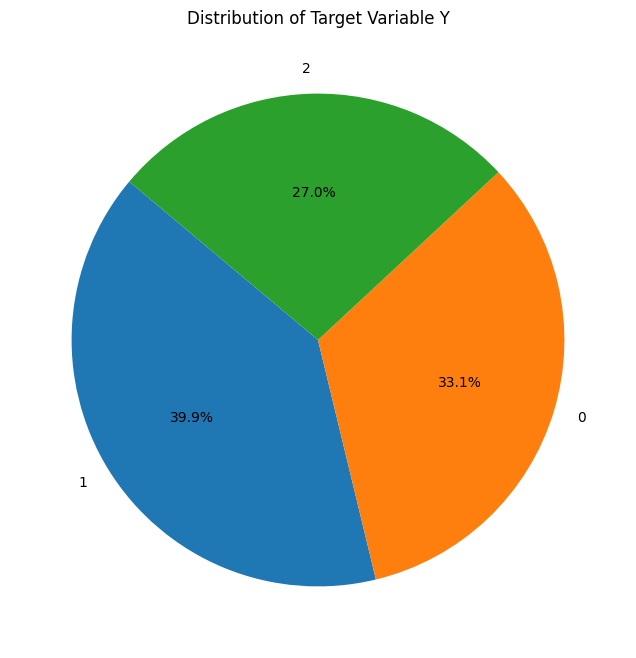

In [173]:
# Get the counts of each unique value in the 'Y' column
y_counts = df['Y'].value_counts()

# Create a pie chart
plt.figure(figsize=(8, 8))
plt.pie(y_counts, labels=y_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Target Variable Y')
plt.show()

This pie chart visually represents the breakdown of the wine samples into three different categories or "classes" labeled 0, 1, and 2. Each slice of the pie shows how large each class is compared to the total number of wine samples. The percentage next to each slice tells you exactly what proportion of the wines belong to that specific class. Looking at the chart, you can quickly see which class has the most samples and how the other classes are distributed in comparison.



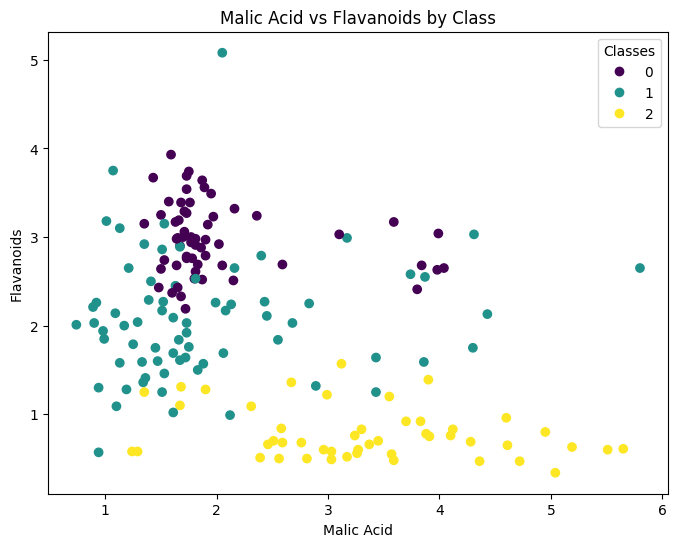

In [174]:
plt.figure(figsize=(8, 6))
scatter = plt.scatter(df['malic_acid'], df['flavanoids'], c=df['Y'], cmap='viridis')
plt.xlabel('Malic Acid')
plt.ylabel('Flavanoids')
plt.title('Malic Acid vs Flavanoids by Class')
legend = plt.legend(*scatter.legend_elements(), title="Classes")
plt.show()

This scatter plot shows the relationship between 'Malic Acid' and 'Flavanoids' for the wine samples, with each point colored according to its class (0, 1, or 2). By observing the plot, the different classes tend to cluster in different areas based on their 'Malic Acid' and 'Flavanoids' values. For example, you might notice if one class generally has higher or lower values for these features compared to the others, which could indicate that these features are useful for distinguishing between the wine classes.



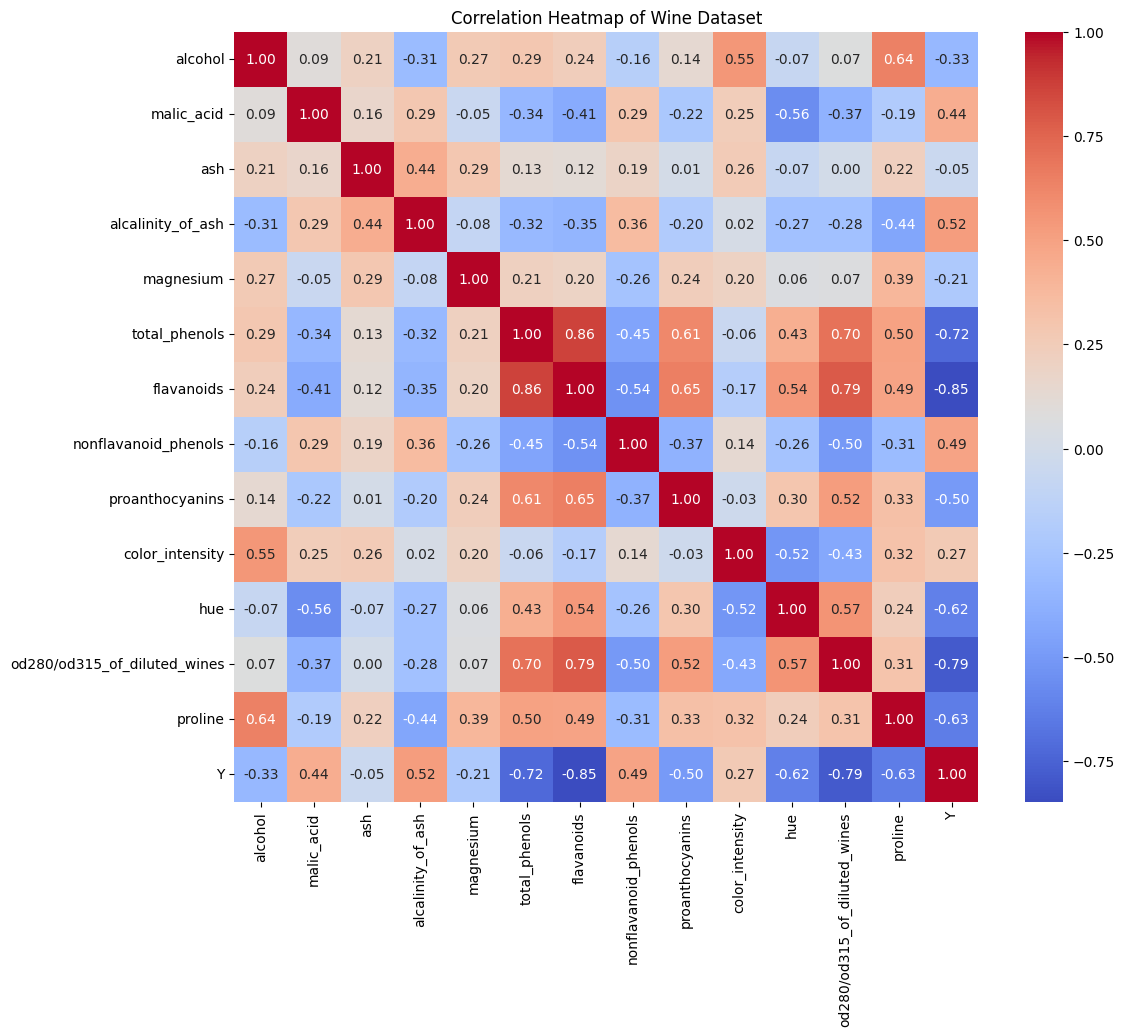

In [183]:
import seaborn as sns

plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Wine Dataset')
plt.show()

Each square in the heatmap represents the correlation coefficient between two variables.
The color of the square indicates the strength and direction of the correlation:
Warm colors (like red) indicate a positive correlation. As one variable increases, the other also tends to increase.
Cool colors (like blue) indicate a negative correlation. As one variable increases, the other tends to decrease.
Lighter or white colors indicate a weak or no linear correlation.
The number inside each square is the correlation coefficient, ranging from -1 to +1:
+1 means a perfect positive linear correlation.
-1 means a perfect negative linear correlation.
0 means no linear correlation.
The diagonal line of dark red squares with '1.00' represents the correlation of a variable with itself, which is always perfect (1).
By examining the heatmap, you can identify:

Strong positive correlations: Look for dark red squares with values close to 1.
Strong negative correlations: Look for dark blue squares with values close to -1.
Weak or no correlations: Look for lighter colored squares with values close to 0.

# Generate Rules with PRISM

In [175]:
# since we dont do any partitioning bcs we have to use both X and Y in our 'prism' model, so let's just use 100 rows for this training and the rest for the testing

# PRISM requires all columns be categorical, so bin any numeric features, including the target column if necessary, BUT there's a binning function in 'get_prism_rules', so we dont need to binning it manually first.

prism = PrismRules()
_ = prism.get_prism_rules(df.head(142), 'Y')


........................................................................
Target: 2
........................................................................
flavanoids = Low AND color_intensity = High
   Support:  the target has value: '2' for 100.000% of the 23 rows matching the rule 
   Coverage: the rule matches: 23 out of 39 rows for target value: '2'. This is:
      58.974% of total rows for target value: '2'
      16.197% of total rows in data
flavanoids = Low AND color_intensity = Med
   Support:  The target has value: '2' for 100.000% of the 15 remaining rows matching the rule
   Coverage: The rule matches: 15 out of 16 rows remaining for target value: '2'. This is:
      93.750% of remaining rows for target value: '2'
      38.462% of total rows for target value: '2'
      10.563% of total rows in data

........................................................................
Target: 0
........................................................................
proline = High AND a

# Bin Ranges Result

In [176]:
# This section only to know the range of the bins
bin_ranges_data = []
for col, ranges in prism.get_bin_ranges().items():
    counts, _ = np.histogram(df[col], bins=ranges)
    for i in range(len(ranges) - 1):
        bin_ranges_data.append({
            'Column': col,
            'Bin': i,
            'Lower Bound': ranges[i],
            'Upper Bound': ranges[i+1],
            'Bin': i,
            'Count': counts[i]
        })

bin_ranges_df = pd.DataFrame(bin_ranges_data)
display(bin_ranges_df)

,Column,Bin,Lower Bound,Upper Bound,Count
0,alcohol,0,11.41,12.51,56
1,alcohol,1,12.51,13.41,58
2,alcohol,2,13.41,14.75,62
3,malic_acid,0,0.74,1.70,63
4,malic_acid,1,1.70,2.58,57
5,malic_acid,2,2.58,5.80,58
6,ash,0,1.36,2.28,59
7,ash,1,2.28,2.48,58
8,ash,2,2.48,3.23,61
9,alcalinity_of_ash,0,10.60,18.00,53


# Test on Y Pred

In [177]:
# we use the rest of our data for testing, in this case is 36 rows, which is 80 for train and 20 for test. (35.6 rounded to 36rows)
y_pred = prism.predict(df.tail(36).drop(columns=['Y']))
f1_score(df.tail(36)['Y'], y_pred, average=None)

array([0.95652174, 0.96774194, 1.        ])

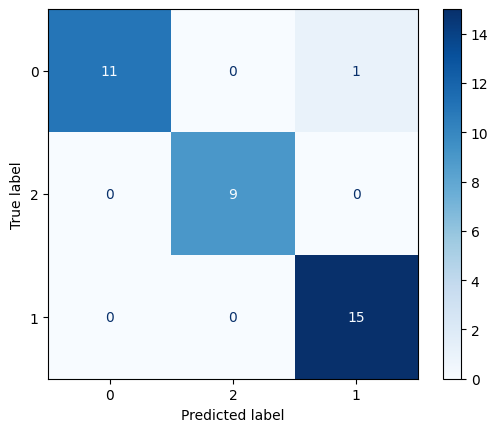

In [178]:
# We next display the confusion matrix.
labels = y_pred.unique()
cm = confusion_matrix(df.tail(36)['Y'], y_pred, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Blues')
plt.show()


Row 0 (Actual Class 0):
*   The top-left cell shows 5. This means 5 instances that were actually Class 0 were correctly predicted as Class 0 (True Positives).
*   The cell to the right shows 5. This means 5 instances that were actually Class 0 were incorrectly predicted as Class 1 (False Negatives).
*   The cell further right shows 0. This means 0 instances that were actually Class 0 were incorrectly predicted as Class 2.

Row 1 (Actual Class 1):
*   The cell in the first column shows 0. This means 0 instances that were actually Class 1 were incorrectly predicted as Class 0.
*   The diagonal cell shows 19. This means 19 instances that were actually Class 1 were correctly predicted as Class 1 (True Positives).
*   The cell to the right shows 0. This means 0 instances that were actually Class 1 were incorrectly predicted as Class 2.

Row 2 (Actual Class 2):
*   The cell in the first column shows 0. This means 0 instances that were actually Class 2 were incorrectly predicted as Class 0.
*   The cell in the second column shows 0. This means 0 instances that were actually Class 2 were incorrectly predicted as Class 1.
*   The bottom-right cell shows 7. This means 7 instances that were actually Class 2 were correctly predicted as Class 2 (True Positives).










In [179]:
# classification report
from sklearn.metrics import classification_report

print(classification_report(df.tail(36)['Y'], y_pred))

              precision    recall  f1-score   support

           0       1.00      0.92      0.96        12
           1       0.94      1.00      0.97        15
           2       1.00      1.00      1.00         9

    accuracy                           0.97        36
   macro avg       0.98      0.97      0.97        36
weighted avg       0.97      0.97      0.97        36



For Class 0:
Precision (1.00): When the model predicts Class 0, it is always correct. There are no false positives for Class 0.
Recall (0.92): The model correctly identifies 92% of the actual Class 0 instances. This means there are a few instances of Class 0 that the model failed to predict as Class 0 (false negatives).
F1-score (0.96): This is a good balance of precision and recall for Class 0.
Support (12): There are 12 actual instances of Class 0 in the test set.

For Class 1:
Precision (0.94): When the model predicts Class 1, it is correct 94% of the time. There are a small number of false positives for Class 1.
Recall (1.00): The model correctly identifies 100% of the actual Class 1 instances. There are no false negatives for Class 1.
F1-score (0.97): This indicates very strong performance for Class 1.
Support (15): There are 15 actual instances of Class 1 in the test set.

For Class 2:
Precision (1.00): When the model predicts Class 2, it is always correct. No false positives for Class 2.
Recall (1.00): The model correctly identifies 100% of the actual Class 2 instances. No false negatives for Class 2.
F1-score (1.00): Perfect performance for Class 2 on this test set.
Support (9): There are 9 actual instances of Class 2 in the test set.

Overall Metrics:
Accuracy (0.97): The model correctly classified 97% of all instances in the test set.
Macro Avg (0.98 precision, 0.97 recall, 0.97 f1-score): The average performance across all classes, treating each class equally.
Weighted Avg (0.97 precision, 0.97 recall, 0.97 f1-score): The average performance, weighted by the number of instances in each class.

In [181]:
# Create new data points for the wine dataset
new_wine_data = {
  'alcohol': [14.0, 14.00],
  'malic_acid': [2.0, 2.0],
  'ash': [2.3, 2.2],
  'alcalinity_of_ash': [19.0, 11.0],
  'magnesium': [95.0, 95.0],
  'total_phenols': [2.2, 2.5],
  'flavanoids': [0.14, 0.5],
  'nonflavanoid_phenols': [0.14, 0.5],
  'proanthocyanins': [1.6, 1.5],
  'color_intensity': [7.0, 6.0],
  'hue': [0.7, 0.6],
  'od280/od315_of_diluted_wines': [3.2, 3.0],
  'proline': [550.0, 1400.0] }

new_wine_df = pd.DataFrame(new_wine_data)

# Predict on the new wine data using the prism model trained on wine data
wine_prediction = prism.predict(new_wine_df)
# Assign predictions to a new column in the DataFrame
new_wine_df['Predicted Class'] = wine_prediction

# Display the new data and prediction
print("New Wine Data Points:")
display(new_wine_df)

New Wine Data Points:


,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,Predicted Class
0,14.0,2.0,2.3,19.0,95.0,2.2,0.14,0.14,1.6,7.0,0.7,3.2,550.0,1
1,14.0,2.0,2.2,11.0,95.0,2.5,0.50,0.50,1.5,6.0,0.6,3.0,1400.0,2


New Wine Data Point 1:

alcohol: High
malic_acid: Med
ash: Med
alcalinity_of_ash: Med
magnesium: Med
total_phenols: Med
flavanoids: Low
nonflavanoid_phenols: Low
proanthocyanins: Med
color_intensity: High
hue: Low
od280/od315_of_diluted_wines: High
proline: Med
New Wine Data Point 2:

alcohol: High
malic_acid: Med
ash: Low
alcalinity_of_ash: Low
magnesium: Med
total_phenols: Med
flavanoids: Low
nonflavanoid_phenols: Med
proanthocyanins: Med
color_intensity: High
hue: Low
od280/od315_of_diluted_wines: Med
proline: High
The PRISM model has a set of rules for each target class (0, 1, and 2). For example, some rules found were:

For Class 2: "flavanoids = Low AND color_intensity = High"
For Class 0: "proline = High AND alcohol = High"
For Class 1: "color_intensity = Low AND alcohol = Low"

Explanation of Predictions:

*   New Wine Data Point 1 (Predicted Class 1):
    The categorized values for this data point are checked against the learned rules.
    While this data point has 'Low' flavanoids and 'High' color intensity, which matches a rule for Class 2, the model predicted Class 1. The PRISM process assigns the class of the first rule that matches the data point. This suggests that, in the model's internal order of checking rules, a rule for Class 1 was found to be satisfied by the features of Data Point 1 before the Class 2 rule was checked or satisfied. The exact Class 1 rule that matched first is not explicitly shown in the printed output, but its satisfaction before other rules led to the Class 1 prediction.
    
*   New Wine Data Point 2 (Predicted Class 2):
    The categorized values for this data point are also checked against the rules. This data point has 'Low' flavanoids and 'High' color intensity. Looking at the rules for Class 2, the rule "flavanoids = Low AND color_intensity = High" is satisfied by these values. Because this rule for Class 2 was satisfied, and PRISM assigns the class of the first matching rule, Data Point 2 was predicted as Class 2. The combination of 'Low' flavanoids and 'High' color intensity is a strong indicator for Class 2 based on the patterns found in the training data.



